# LSTM with 1D CNN


Mount google drive

In [ ]:
from google.colab import drive          
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install libraries

In [ ]:
!pip install wfdb #install wfdb library on colab
!pip install tqdm ##install tqdm library on colab
!pip install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize , LabelEncoder
import os
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim 
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.utils.data as data_utils
import torchvision.transforms as transforms  


Set torch to CPU

In [ ]:
#set torch to CPU

device = torch.device('cpu')


Useful constants

In [ ]:
train_files = [
    "a01",
    "c01",
    "b01",
    "a02",
    "c02",
    "b02",
    "a03",
    "c03",
    "b03",
    "a04",
    "c04",
    "b04",
    "a05",
    "c05",
    "a06",
    "c06",
    "a07",
    "c07",
    "a08",
    "c08",
    "a09",
    "a10",
    "a11",
    "a12",
    "a13",
    "a14",
    "a15",
    "a16",
]

test_files = ["b05", "c09", "c10", "a17", "a18", "a19", "a20"]


path = "/content/drive/MyDrive/ML/Dataset/Apnea/apnea-ecg-database-1.0.0/"  # path of dataset file


## defintion of bandpass filter

In [ ]:
from scipy import signal


def bandpass_signal(xn, lower, upper):
    length = len(xn)
    t = np.linspace(-1, 1, length)

    b, a = signal.butter(3, [lower, upper], btype="bandpass", fs=100)

    zi = signal.lfilter_zi(b, a)

    z, _ = signal.lfilter(b, a, xn, zi=zi * xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi * z[0])
    y = signal.filtfilt(b, a, xn)

    return y


## Extract training , for LSTM we store each recording per subject in a dictionary which keys are the subject identifiers

In [ ]:
dictionnary_train_subjects = {}
for idx, file in enumerate(train_files):
    path_dat = os.path.join(path, file)
    record = wfdb.rdrecord(path_dat, channels=[0])
    apnea = wfdb.rdann(path_dat, "apn")
    length = min(
        len(apnea.symbol) - 1, math.floor(((record.p_signal.shape[0] - 3000) / 6000))
    )
    apnea_labels_per_subject = np.zeros((length))
    ecg_readings_per_subject = np.zeros((length, 6000))
    ecg = record.p_signal
    ecg = ecg.reshape(len(ecg))
    # filter
    ecg_with_filter = bandpass_signal(ecg, 1, 48)
    for j in range(length):
        # store for subject
        apnea_labels_per_subject[j] = 1 if apnea.symbol[j + 1] == "A" else 0
        ecg_readings_per_subject[j] = ecg_with_filter[
            3000 + (6000 * j) : 3000 + (6000 * (j + 1))
        ]

    ecg_readings_per_subject = np.array(ecg_readings_per_subject)
    apnea_labels_per_subject = np.array(apnea_labels_per_subject)
    # normalize add both labels and signals for each subject entry
    dictionnary_train_subjects[idx] = [
        normalize(ecg_readings_per_subject, norm="max"),
        apnea_labels_per_subject,
    ]



KeyboardInterrupt: ignored

We do the same for the test set

In [ ]:
dictionnary_test_subjects = {}
for idx, file in enumerate(test_files):
    path_dat = os.path.join(path, file)
    record = wfdb.rdrecord(path_dat, channels=[0])
    apnea = wfdb.rdann(path_dat, "apn")
    length = min(
        len(apnea.symbol) - 1, math.floor(((record.p_signal.shape[0] - 3000) / 6000))
    )
    apnea_labels_per_subject = np.zeros((length))
    ecg_readings_per_subject = np.zeros((length, 6000))
    # ecg_with_filter = butter_bandpass_filter(record.p_signal, 1,48,fs = 100)
    ecg = record.p_signal
    ecg = ecg.reshape(len(ecg))
    ecg_with_filter = bandpass_signal(ecg, 1, 48)
    for j in range(length):
        # store for subject
        apnea_labels_per_subject[j] = 1 if apnea.symbol[j + 1] == "A" else 0
        ecg_readings_per_subject[j] = ecg_with_filter[
            3000 + (6000 * j) : 3000 + (6000 * (j + 1))
        ]

    ecg_readings_per_subject = np.array(ecg_readings_per_subject)
    apnea_labels_per_subject = np.array(apnea_labels_per_subject)
    dictionnary_test_subjects[idx] = [
        normalize(ecg_readings_per_subject, norm="max"),
        apnea_labels_per_subject,
    ]

## DataSet Class

Our Dataset class, as attributes it has one dictionary of subject with associated recordings and labels as attribute to store a mapping annotations and png filenames. We also store the sequence length of lstm as attribute.

In the train set, to get one item, one retrieves a randomly chosen ordered sequence of 1 min segments of one subject, with associated labels. In the __getitem__ method the index oorresponds to the index of a subject. An epoch is therefore one iteration over all subjects.

In the test set, the __getitem__ works similarly but we take the biggest number of sequences from one subjects in order, so not it's not random. This is necessary in order to calculate accuracy on the test set properly

In [ ]:
class Ecg_Per_Subject_DataSet(Dataset):
    # dictionnary of "userId" a tuple of (ecg values) matrix and annotations
    def __init__(self, dictionnary, sequence_length, transform=None):
        self.dictionnary = dictionnary  # load data input and output from csv file
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.dictionnary)  # return length of csv file

    def __getitem__(self, index):
        nb_minutes_for_subject = len(self.dictionnary[index][1])
        starting_point = random.randint(
            0, nb_minutes_for_subject - self.sequence_length
        )

        y_label_sequence = torch.tensor(
            self.dictionnary[index][1][
                starting_point : starting_point + self.sequence_length
            ]
        )

        y_label_sequence = y_label_sequence[:, None]
        x_sequence = torch.tensor(
            self.dictionnary[index][0][
                starting_point : starting_point + self.sequence_length
            ]
        )

        return (x_sequence.unsqueeze(1), y_label_sequence)



class Ecg_Per_Subject_Test_DataSet(Dataset):
    # dictionnary of "userId" a tuple of (ecg values) matrix and annotations
    def __init__(self, dictionnary, sequence_length, transform=None):
        self.dictionnary = dictionnary  # load data input and output from csv file
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.dictionnary)  # return length of csv file

    def __getitem__(self, index):
        nb_minutes_for_subject = len(self.dictionnary[index][1])
        #the number of minutes should be a multiple of the sequence length
        nb_used_minutes_for_subject = nb_minutes_for_subject - (
            nb_minutes_for_subject % self.sequence_length
        )
        y_label_sequence = torch.tensor(
            self.dictionnary[index][1][:nb_used_minutes_for_subject]
        ).reshape(
            (nb_used_minutes_for_subject // self.sequence_length, self.sequence_length)
        )
        #reshape to have separation between sequences
        x_sequence = torch.tensor(
            self.dictionnary[index][0][:nb_used_minutes_for_subject]
        ).reshape(
            (
                nb_used_minutes_for_subject // self.sequence_length,
                self.sequence_length,
                -1,
            )
        )

        return ((x_sequence.unsqueeze(2)), (y_label_sequence.unsqueeze(2)))
   

## Hyperparameters


In [ ]:
in_channels = 1
num_classes = 1
learning_rate = 1e-4
batch_size = 32
num_epochs = 2000
sequence_length = 10

## Create the loaders


In [ ]:
train_set = Ecg_Per_Subject_DataSet(dictionnary_train_subjects, sequence_length)
test_set = Ecg_Per_Subject_Test_DataSet(dictionnary_test_subjects, sequence_length)
train_loader = DataLoader(dataset= train_set, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(dataset= test_set, batch_size = 1, shuffle =True)



# **Train model**

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_layers, hidden_size, in_channels=1, num_classes=1):
        super(CNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, out_channels=8, kernel_size=5, padding=2, stride=1
        )
        # convolution to extract features from data
        self.pool1 = nn.MaxPool1d(kernel_size=6, stride=6)

        self.conv2 = nn.Conv1d(
            in_channels=8, out_channels=16, kernel_size=5, padding=2, stride=1
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(
            in_channels=16, out_channels=32, kernel_size=7, padding=2, stride=1
        )
        self.conv4 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=3, padding=2, stride=1
        )

        self.lstm = nn.LSTM(
            input_size=8000,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.5,
        )
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        B, L, channels, feature_sequence = x.size()

        x = x.reshape(B * L, channels, feature_sequence)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.reshape((B, L, -1))

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        x, _ = self.lstm(x, (h0, c0))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = torch.sigmoid(self.fc4(x))

        return x

In [ ]:

model = CNN(1, 128,in_channels=in_channels, num_classes=num_classes).to(device)

#loss and optimizer
criterion =  nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Network and calculate accuracy and loss

In [ ]:
from tqdm import tqdm

losses = []
accur = []
losses_test = []
accur_test = []
test_targets = []
test_scores = []
for epoch in range(num_epochs):
    acc_test = 0
    acc = 0
    nb_iter_train = 0
    nb_iter_test = 0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        data = data.float()
        print(data.size())
        targets = targets.float()
        # forward

        scores = model(data)
        loss = criterion(scores, targets)
        # calculate accuracy and loss
        targets_array = targets.reshape(-1, 1)
        scores_array = (scores.reshape(-1, 1) > 0.5).float()  # astype('float32')
        nb_iter_train += len(scores_array)
        acc += (targets_array == scores_array).sum().item()
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    # for test dataset
    for batch_idx, (data_test, targets_test) in enumerate(tqdm(test_loader)):
        # the batch size is the whole data for one subject
        data_test = data_test[0]
        targets_test = targets_test[0]
        data_test = data.float()
        targets_test = targets.float()
        scores_test = model(data_test)

        loss_test = criterion(scores_test, targets_test)
        # calculate accuracy and loss
        targets_array_test = targets_test.reshape(-1, 1)
        # print("\n scores_array_test ", scores_test.reshape (-1,1).size())
        scores_array_test = (scores_test.reshape(-1, 1) > 0.5).float()
        acc_test += (targets_array_test == scores_array_test).sum().item()
        nb_iter_test += len(scores_array_test)
        if epoch == num_epochs - 1:
            for i in range(targets_array_test.shape[0]):
                test_targets.append(int(targets_array_test[i][0]))
                test_scores.append(int(scores_array_test[i][0]))
    acc = acc / nb_iter_train
    acc_test = acc_test / nb_iter_test
    losses.append(loss)  # .detach().numpy())
    accur.append(acc)
    losses_test.append(loss_test)  # .detach().numpy())
    accur_test.append(acc_test)
    print(
        "\n epoch {}\tloss_train : {}\t accuracy_train : {}%".format(
            epoch, loss, acc * 100
        )
    )
    print(
        "epoch {}\tloss_test : {}\t accuracy_test : {}%\n".format(
            epoch, loss_test, acc_test * 100
        )
    )
  

# Testing

This function returns the true_positives, false_positives, true_negatives, false_negatives

In [ ]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """
    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

This function iterates through the test_loader, and calculates the different useful metrics: sensitivity, specificity, F1, Youden's index and accuracy. It also generates a confusion matrix using seaborn.

Checking accuracy on test data
Got 61.55487804878049 accuracy 
Sensitivity: 0.44282029234737746
Specificity: 0.7104393008974964
F1: 0.44958533391532085
Youden's index: 0.15325959324487393


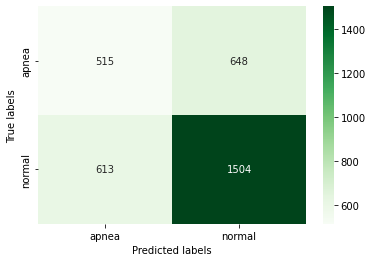

In [ ]:
def check_test_accuracy(model):
    model.eval()
    accuracy = 0.0
    total = 0.0
    print("Checking accuracy on test data")
    with torch.no_grad():
        true_positives, false_positives, true_negatives, false_negatives = 0, 0, 0, 0
        predicted_tot = torch.zeros(0)
        labels_tot = torch.zeros(0)

        for data in test_loader:
            segments, labels = data
            # take only one batch
            segments = segments[0]
            # take onle one batch
            labels = labels[0]
            B, L, _, _ = segments.size()
            labels = labels.reshape(B * L, -1)
            # run the model on the test set to predict labels
            segments = segments.float()
            outputs = model(segments)

            predicted = torch.round(outputs)

            # reshape for confusion computations

            predicted = predicted.reshape(B * L, -1)
            labels = labels.reshape(B * L, -1)

            tp, fp, tn, fn = confusion(predicted, labels)

            true_positives += tp
            false_positives += fp
            true_negatives += tn
            false_negatives += fn

            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

        # compute the accuracy over all test segment
        accuracy = 100 * accuracy / total
        print(f"Got {accuracy} accuracy ")

        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1 = (2 * precision * recall) / (precision + recall)

        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")
        print(f"F1: {F1}")
        print(f"Youden's index: {sensitivity + specificity - 1 }")

        # Plot confusion matrix

        cm = [[true_positives, false_negatives], [false_positives, true_negatives]]

        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt="g", cmap="Greens", ax=ax)
        # annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        # ax.set_title('Confusion Matrix');
        ax.xaxis.set_ticklabels(["apnea", "normal"])
        ax.yaxis.set_ticklabels(["apnea", "normal"])


check_test_accuracy(model)